<a href="https://colab.research.google.com/github/estherc247/cz4041_ML/blob/main/IRV2_adam_clean_epsilon0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import data from Google Drive 
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
#Import Libraries 
import tensorflow as tf 
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd 
from PIL import Image
import glob
import os 
from os import listdir
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns
import csv

In [3]:
#Load Data
import shutil
data_dir_train = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_sharpened'
data_dir_test = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/'
TEST_DATA_FOLDER = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_sharpened'

In [4]:
#For inceptionresnetv2
batch_size = 32
img_width = 299
img_height = 299
epochs = 20

In [5]:
#Split data 
train_image_data = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1.0/255.0,
    rotation_range = 30,
    horizontal_flip = True, 
    vertical_flip = True,
    zoom_range=0.4, 
    shear_range = 0.3
)

#[3803 images belonging to 12 class]
train_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="training")

#[947 images belonging to 12 class]
val_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="validation")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [ ]:
# !mkdir '/test_data'
# test_destination = '/test_data'
# shutil.move(NEW_TEST_DATA_FOLDER, test_destination)

In [6]:
#Initialise test generator [794 images belonging to 1 class]
test_image_data = ImageDataGenerator(rescale=1./255)
test_ds = test_image_data.flow_from_directory(data_dir_test,
                                              classes=['test_sharpened'],
                                              target_size=(img_height,img_width),
                                              batch_size = 1,
                                              class_mode ='categorical',
                                              shuffle = False)

Found 794 images belonging to 1 classes.


In [7]:
train_steps = train_ds.samples//batch_size
val_steps = val_ds.samples//batch_size
test_steps = test_ds.samples

In [8]:
#Model 3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

#Transfer Learning
# base_model = InceptionResNetV2(include_top=False, weights='imagenet')
# base_model.trainable = False

input_layer = tf.keras.layers.Input(shape=(img_width, img_height, 3))
base_model = InceptionResNetV2(include_top=False, weights='imagenet')(input_layer)
flat_layer = tf.keras.layers.Flatten()(base_model)
dense_layer_1 = tf.keras.layers.Dense(128, activation='relu')(flat_layer)
drop_layer = tf.keras.layers.Dropout(0.2)(dense_layer_1)
output_layer = tf.keras.layers.Dense(12, activation='softmax')(drop_layer)

model = tf.keras.Model(input_layer, output_layer)
model.summary()

219070464/219055592 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               12583040  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 66,921,324
Trainable params: 66,860,780
Non-tr

In [10]:
#Compile model 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0005, epsilon=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
#Save model checkpoint
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
#Train Model
history = model.fit(
                train_ds,
                steps_per_epoch = train_steps,
                validation_data = val_ds, 
                validation_steps = val_steps,
                epochs = epochs, 
                callbacks=[model_checkpoint_callback])

Epoch 1/20
118/118 [==============================] - 2183s 18s/step - loss: 2.3077 - accuracy: 0.2159 - val_loss: 1.9979 - val_accuracy: 0.3157
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/20
118/118 [==============================] - 334s 3s/step - loss: 1.5705 - accuracy: 0.4755 - val_loss: 1.1619 - val_accuracy: 0.6304
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/20
118/118 [==============================] - 334s 3s/step - loss: 0.9499 - accuracy: 0.6805 - val_loss: 0.7078 - val_accuracy: 0.7651
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/20
118/118 [==============================] - 334s 3s/step - loss: 0.6329 - accuracy: 0.7735 - val_loss: 0.5713 - val_accuracy: 0.8200
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/20
118/118 [==============================] - 333s 3s/step - loss: 0.5003 - accuracy: 0.8247 - val_loss: 0.4545 - val_accuracy: 0.8491
INFO:tensorflow:Assets written to: /tmp/checkpoint/

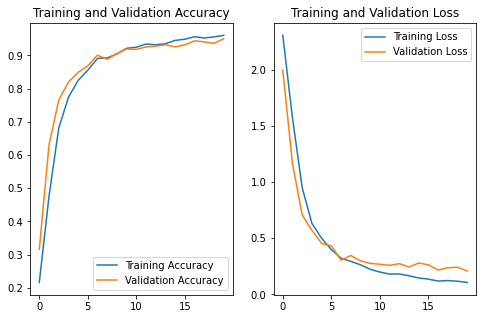

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
model.evaluate(generator=val_ds, steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.22724361717700958, 0.9418103694915771]

In [15]:
test_ds.reset() #maintain test order
test_predictions = model.predict_generator(test_ds, test_steps, verbose=1 )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


794/794 [==============================] - 432s 538ms/step


In [16]:
import numpy as np
predicted_plant_type = np.argmax(test_predictions, axis=1)

labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_plant_type]

test_pred = []
filenames=test_ds.filenames
for name in range(len(filenames)):
   test_pred.append(filenames[name].split('/')[1])

results=pd.DataFrame({"file":test_pred,
                      "species":predictions})
results.to_csv("submission.csv",index=False)